<center><h1>Lark Technologies Data Analyst Take Home Assignment</h1></center>
<center><h2>Haoran Zeng</h2></center>

<h3>Main Objectives</h3>

- Understand how users interact with the app.

- Understand how users are reacting to the missions feature.

- Why and when engagement drops off.

- Engagement improvement suggestions.

<h3>Resources Used</h3>

- Python Version: 3.8

- Packages: pandas, numpy, calendar, matplotlib, seaborn, h2o, sklearn

In [61]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2ORandomForestEstimator
from sklearn.metrics import mean_absolute_error

<h3>Data Used</h3>

- user_mission.csv

    - Information about when a user started and finished a mission

    - 27983 entries and 4 columns

    - Mission start date: 2018-10-03 - 2018-12-31

    - Mission end date: 2018-10-09 - 2020-06-23

- agg_info.csv

    - User-daily engagement metrics

    - 468040 entries and 8 columns

    - Records date: 2018-10-01 - 2019-01-07

<h3>Executive Summary</h3>

- Mission Feature

    - Average number of conversations, average number of meals, and total login count are the top 3 important features in terms of predicting how many missions a user completes. The average number of meals metric is the most actionable one. I suggest Lark to send reminder emails or use incentive programs to encourage users whose average number of meals is below 2.5 to record more meals information. The marginal effects for users who already have more than 2.5 average number of meals are minimal, I recommend that Lark do not spend too many resources on those users.

    - The conversion rates dropped after the fifth mission. I suggest Lark to reward customers who participate mission 6 - 16 and collect customers feedbacks on mission 6, 9, 12, and 13, because their conversion rates dropped significantly comparing with conversion rates of their previous missions.

    - Users preferred not to launch missions and interact with the app during holidays and weekends, and users who frequently logged in on Mondays and Tuesdays generally achieved a higher average number of missions. I recommend Lark to send reminder conversations or rewards to encourage users to participate missions during holidays and weekends. Additionally, I suggest Lark to investigate the demographic and behavioral infromation of those who actively participated during Mondays and Tuesdays and spend resources to acquire similar users and retain them.

    - Majority of the missions were completed within 10 days. I suggest Lark to send reminders to users who engaged in a mission but did not finish it within 10 days.

- Other Engagement Metrics

    - Users generally interacted less during holidays and weekends. I recommend Lark to reward users for consecutive logins and activity participations.

    - Lots of logins happened during the first week of a month, but those logins did not contribute many conversations. I suggeset Lark to check if there were any technical bugs during these weeks and send more customized conversations during the first week of each month to encourage users to interact with the conversation feature.

    - Users generally did not spend more than 150 minutes on activities per login session. I recommend Lark to improve activity experiences by investigating why some users spent extremely long times on activities.

<h2>Data Collection</h2>

In [62]:
user_mission_df = pd.read_csv("user_mission.csv")
agg_info_df = pd.read_csv("agg_info.csv")

- user_mission.csv

    - Information about when a user started and finished a mission.

    - A user can participate multiple missions.

    - Incompleted missions have no end_timestamp.

    - One cannot complete a mission in less than 5 days.

In [63]:
user_mission_df.head()

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
0,2018-10-08 14:32:31+00:00,2018-10-16 00:23:35+00:00,True,1411458
1,2018-10-16 00:23:35+00:00,NaN,False,1411458
2,2018-10-19 19:16:52+00:00,2018-10-27 00:25:26+00:00,True,1424093
3,2018-10-27 00:25:26+00:00,2018-11-02 17:05:29+00:00,True,1424093
4,2018-11-10 18:43:20+00:00,NaN,False,1424093


In [64]:
user_mission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27983 entries, 0 to 27982
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   START_TIMESTAMP  27983 non-null  object
 1   END_TIMESTAMP    23992 non-null  object
 2   COMPLETED        27983 non-null  bool  
 3   USER_ID          27983 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 683.3+ KB


END_TIMESTAMP has null values. Because all incompleted missions have no end date.

In [65]:
# adjust dtype
for i in ["START_TIMESTAMP", "END_TIMESTAMP"]:
    user_mission_df[i] = pd.to_datetime(user_mission_df[i])
agg_info_df["PST_DATE"] = pd.to_datetime(agg_info_df["PST_DATE"])

In [66]:
# Timeframe
print("Earliest mission strat date:\t {}".format(user_mission_df["START_TIMESTAMP"].min()))
print("Latest mission strat date:\t {}".format(user_mission_df["START_TIMESTAMP"].max()))
print("Earliest mission end date:\t {}".format(user_mission_df["END_TIMESTAMP"].min()))
print("Latest mission end date:\t {}".format(user_mission_df["END_TIMESTAMP"].max()))

Earliest mission strat date:	 2018-10-03 03:57:20+00:00
Latest mission strat date:	 2018-12-31 23:57:27+00:00
Earliest mission end date:	 2018-10-09 18:43:04+00:00
Latest mission end date:	 2020-06-23 00:12:23+00:00


- agg_info.csv

    - User-daily engagement metrics.

    - Each row represents a session, including engagement related information.

In [67]:
agg_info_df.head()

,USER_ID,PST_DATE,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
0,423344,2018-11-03,0.0,0,61.600000,40,0.0,0.0
1,427412,2018-10-24,0.0,0,21.900000,25,0.0,0.0
2,427412,2018-10-25,0.0,0,39.250000,26,0.0,0.0
3,652251,2018-12-14,0.0,0,124.333336,56,0.0,3.0
4,658572,2018-11-18,0.0,0,222.516660,49,0.0,0.0


In [68]:
agg_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468040 entries, 0 to 468039
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   USER_ID                    468040 non-null  int64         
 1   PST_DATE                   468040 non-null  datetime64[ns]
 2   NUM_CONVOS                 468040 non-null  float64       
 3   NUM_ALL_MEALS              468040 non-null  int64         
 4   TOTAL_ACTIVITY_MINUTES2    468040 non-null  float64       
 5   NUM_ACTIVITY_MEASUREMENTS  468040 non-null  int64         
 6   NUM_WEIGHTS                468040 non-null  float64       
 7   NUM_NOTIFS                 468040 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 28.6 MB


In [69]:
print("Earliest agg_info date:\t\t {}".format(agg_info_df["PST_DATE"].min()))
print("Latest agg_info date:\t\t {}".format(agg_info_df["PST_DATE"].max()))

Earliest agg_info date:		 2018-10-01 00:00:00
Latest agg_info date:		 2019-01-07 00:00:00


In [70]:
agg_info_df.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,4.680400e+05,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000
mean,1.435944e+06,1.286268,1.025720,64.223719,22.624470,0.205856,2.024250
std,6.840553e+04,1.897220,1.448358,68.212569,20.315924,0.650339,1.280762
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.422975e+06,0.000000,0.000000,15.966666,6.000000,0.000000,1.000000
50%,1.441788e+06,1.000000,0.000000,46.283333,19.000000,0.000000,2.000000
75%,1.466286e+06,2.000000,2.000000,90.150000,35.000000,0.000000,3.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000


<h2>Data Wrangling</h2>

- Datetime parsing

In [71]:
# Engineer datetime related features for future analysis

user_mission_df["time_diff"] = (user_mission_df["END_TIMESTAMP"] - user_mission_df["START_TIMESTAMP"]).dt.days # days a user spent to complete a mission
user_mission_df["start_dow"] = user_mission_df["START_TIMESTAMP"].dt.day_name() # weekday of start day
user_mission_df["end_dow"] = user_mission_df["END_TIMESTAMP"].dt.day_name() # weekday of end day
user_mission_df["start_dom"] = user_mission_df["START_TIMESTAMP"].dt.day # day of month of start day
user_mission_df["end_dom"] = user_mission_df["END_TIMESTAMP"].dt.day # day of month of end day
user_mission_df["start_month"] = user_mission_df["START_TIMESTAMP"].dt.month # month of start day
user_mission_df["end_month"] = user_mission_df["END_TIMESTAMP"].dt.month # month of end day

agg_info_df["dow"] = agg_info_df["PST_DATE"].dt.day_name() # weekday of the record date
agg_info_df["dom"] = agg_info_df["PST_DATE"].dt.day # day of the month of the record date
agg_info_df["month"] = agg_info_df["PST_DATE"].dt.month # month of the record date

- Drop invalid mission records (drop mission records which were completed in 5 days) and duplicates

In [72]:
# Delete invalid mission records

mission_df = user_mission_df[(user_mission_df["time_diff"] >= 5) | (pd.isnull(user_mission_df["time_diff"]))]

In [73]:
agg_info_df.duplicated().sum() # Duplicates check

0

In [74]:
mission_df.duplicated().sum() # Duplicates check

21

In [75]:
# Drop duplicates

mission_df = mission_df.drop_duplicates()

- Create mission_id column for future analysis

In [76]:
# user rank function to label each mission. e.g. for each user_id, his/her first mission will be labeled 1, the second will be labeled 2... (since the order of the missions is the same for all users)

mission_df["mission_id"] = mission_df.groupby("USER_ID")["START_TIMESTAMP"].rank(method = "first")

- Create a data frame for future analysis and machine learning model training

    - Aggregate mission table by user_id and count how many completed missions for each user.

    - Aggregate user_info table by user_id to get general engagement information for each user.

    - Merge the two aggregated tables so we have the information about how each user interact with the app and how the user reacts to the mission feature.

In [77]:
# Build a new data frame for future analysis

# Aggregate mission table by userID to get how many missions each user completed

mission_count_df = mission_df[mission_df["COMPLETED"] == True]["USER_ID"].value_counts().reset_index().rename(columns = {"index":"USER_ID", "USER_ID":"mission_count"})

# Aggregate agg_info table by userID to get user behavioral data 

user_info_df = agg_info_df.groupby("USER_ID").agg(
    avg_convos = ("NUM_CONVOS", np.mean),
    total_convos = ("NUM_CONVOS", np.sum),
    avg_meals = ("NUM_ALL_MEALS", np.mean),
    avg_activity_time = ("TOTAL_ACTIVITY_MINUTES2", np.mean),
    avg_activity_num = ("NUM_ACTIVITY_MEASUREMENTS", np.mean),
    avg_num_weights = ("NUM_WEIGHTS", np.mean),
    avg_num_notifs = ("NUM_NOTIFS", np.mean),
    total_login_count = ("PST_DATE", "count"), # record a user's total login times by count how many rows of engagement records of the user
    favorite_dow = ("dow", lambda x:x.value_counts().index[0]) # record a user's favorite login day
).reset_index()

# Merge the two tables use left join so we keep all user_id

df = user_info_df.merge(mission_count_df, how = "left", on = "USER_ID").fillna(0) # use fillna to record 0 for users who never complete a single mission

In [78]:
df.head()

,USER_ID,avg_convos,total_convos,avg_meals,avg_activity_time,avg_activity_num,avg_num_weights,avg_num_notifs,total_login_count,favorite_dow,mission_count
0,164106,1.545455,102.0,1.818182,134.143921,76.348485,0.348485,1.924242,66,Monday,7.0
1,185934,1.815789,69.0,1.157895,116.771527,35.157895,0.710526,1.631579,38,Tuesday,2.0
2,277541,0.631579,36.0,0.807018,49.503150,29.561404,0.210526,2.421053,57,Monday,3.0
3,423344,0.200000,9.0,0.044444,9.670741,7.222222,0.022222,2.333333,45,Monday,0.0
4,427412,1.230769,96.0,1.307692,32.025214,17.282051,0.192308,2.179487,78,Monday,8.0


<h2>Exploratory Data Analysis</h2>

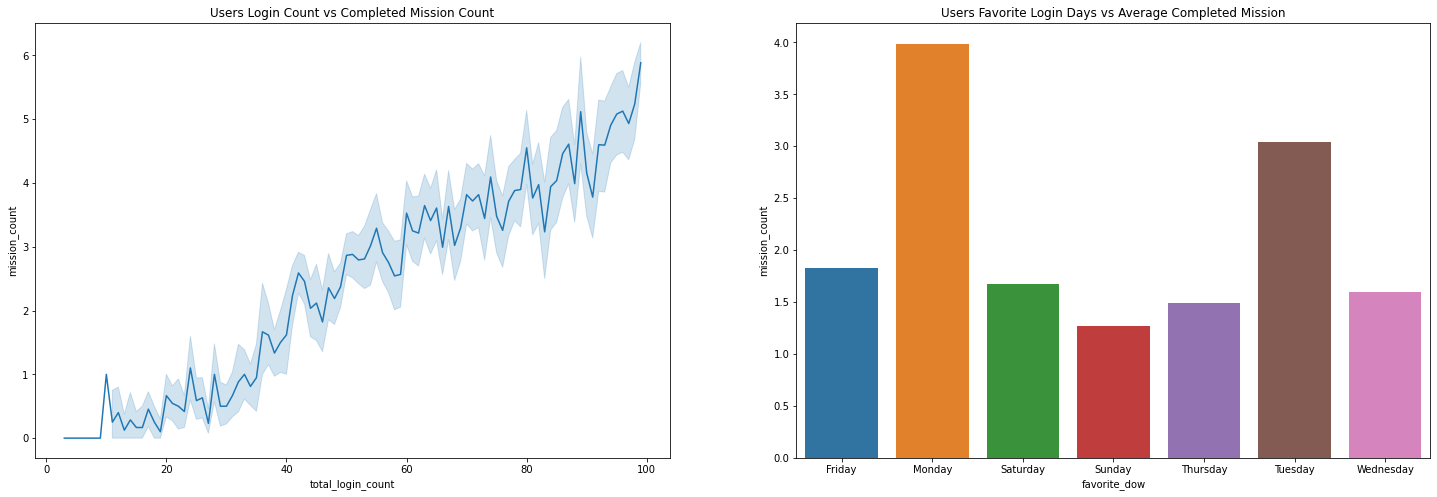

In [79]:
# Users behavioral data analysis based on the aggregated table

fig, axs = plt.subplots(1, 2, figsize = (25, 8))

sns.lineplot(x = "total_login_count", y= "mission_count", data = df, ax = axs[0])
sns.barplot(x = "favorite_dow", y = "mission_count", data = df.groupby("favorite_dow").mean().reset_index(), ax = axs[1])

axs[0].set_title("Users Login Count vs Completed Mission Count")
axs[1].set_title("Users Favorite Login Days vs Average Completed Mission")
plt.show()

Insights:

- (Left figure): plot the relationship between the total login times and total number of completed missions

   - Users total login time is correlated with the number of completed missions. Because users who actively participate missions need to login more frequently to complete the missions by doing conversations. Additionally, users who actively interact with the app are those who value their health conditions, thus they tend to participate more missions. We do not know the causality between the two metrics, but we can reasonably assume that we can improve users engagement by:
      
      - Improve users login times by introducing more customized or interesting missions, or

      - Improve missions completion rate by encouraging users to login more frequently

- (Right figure): countplot shows the relationship between users' favorite login day and the average number of completed missions

   - Users who are more likely to interact the app on Monday and Tuesday achieved a higher average number of completed missions. People who like interacting with the app on these days share some similarities. Monday and Tuesday are the first two days of workdays, people who keep monitoring/recording their health conditions on these days are persistent and take their health seriously, so they are more likely to complete missions. 

   - We can encourage users to persistently monitor their health conditions by introducing some incentive programs. Similar to Snapshot discount of Progressive Insurance, Lark can persuade its health insurance partners to give discounts to users who persistently record and monitor their health conditions. Once users pick up this habit, we probably will see an improvement of average number of completed missions metric. 

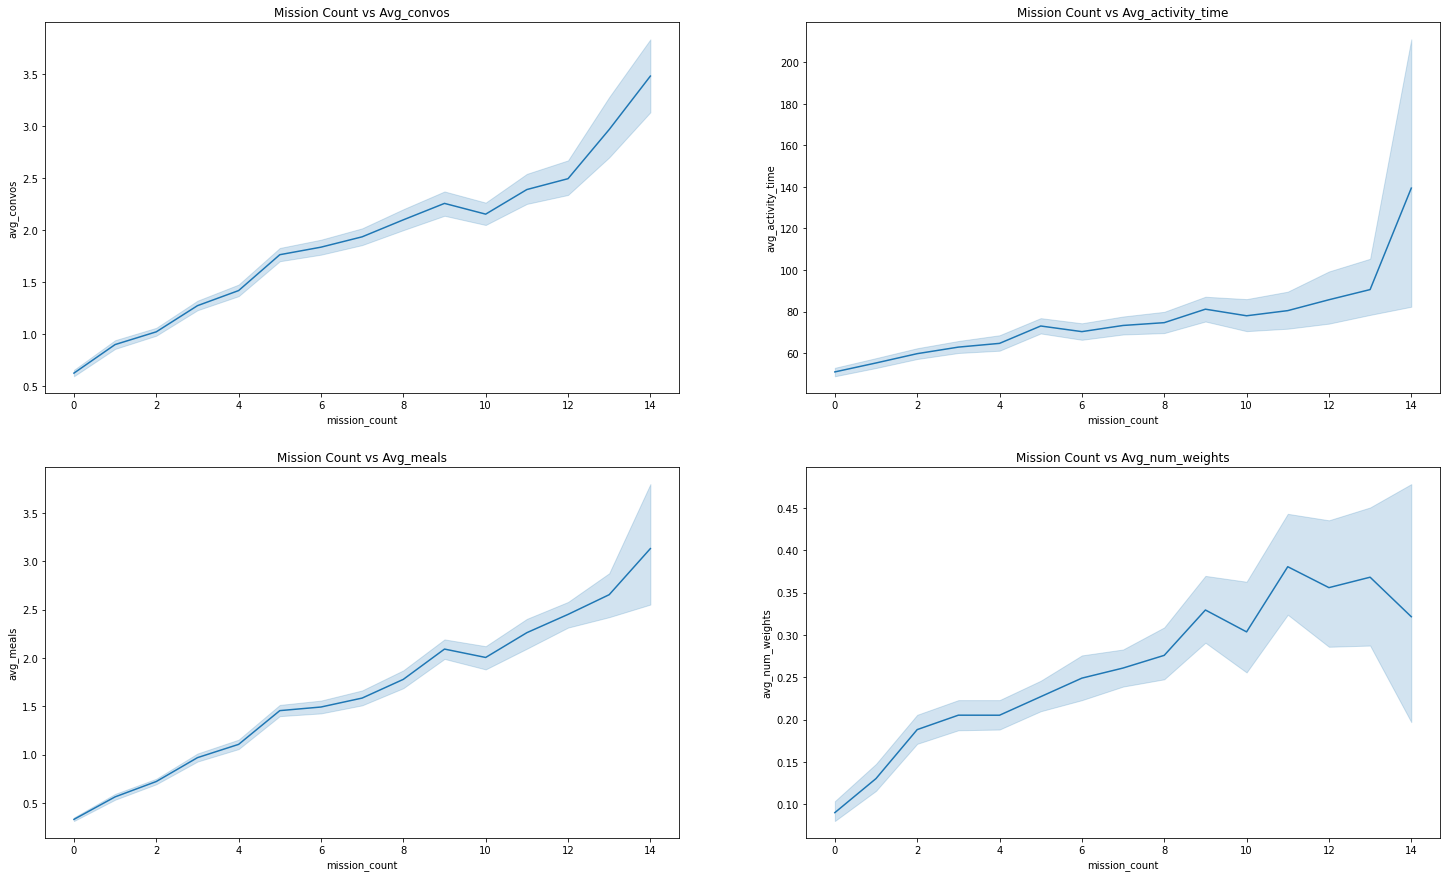

In [20]:
# Users behavioral data analysis based on the aggregated table

fig, axs = plt.subplots(2, 2, figsize = (25, 15))

sns.lineplot(x = "mission_count", y= "avg_convos", data = df, ax = axs[0, 0])
sns.lineplot(x = "mission_count", y = "avg_activity_time", data = df, ax = axs[0, 1])
sns.lineplot(x = "mission_count", y = "avg_meals", data = df, ax = axs[1, 0])
sns.lineplot(x = "mission_count", y = "avg_num_weights", data = df, ax = axs[1, 1])

axs[0, 0].set_title("Mission Count vs Avg_convos")
axs[0, 1].set_title("Mission Count vs Avg_activity_time")
axs[1, 0].set_title("Mission Count vs Avg_meals")
axs[1, 1].set_title("Mission Count vs Avg_num_weights")
plt.show()

Insights:

- General positive relationships between the number of completed missions and average conversation/average activity time/average number of meals/average number of weights. 

- Total login times can be seen as a good proxy of those engagement metrics. Since users who login more often usually initiate those key features more often.

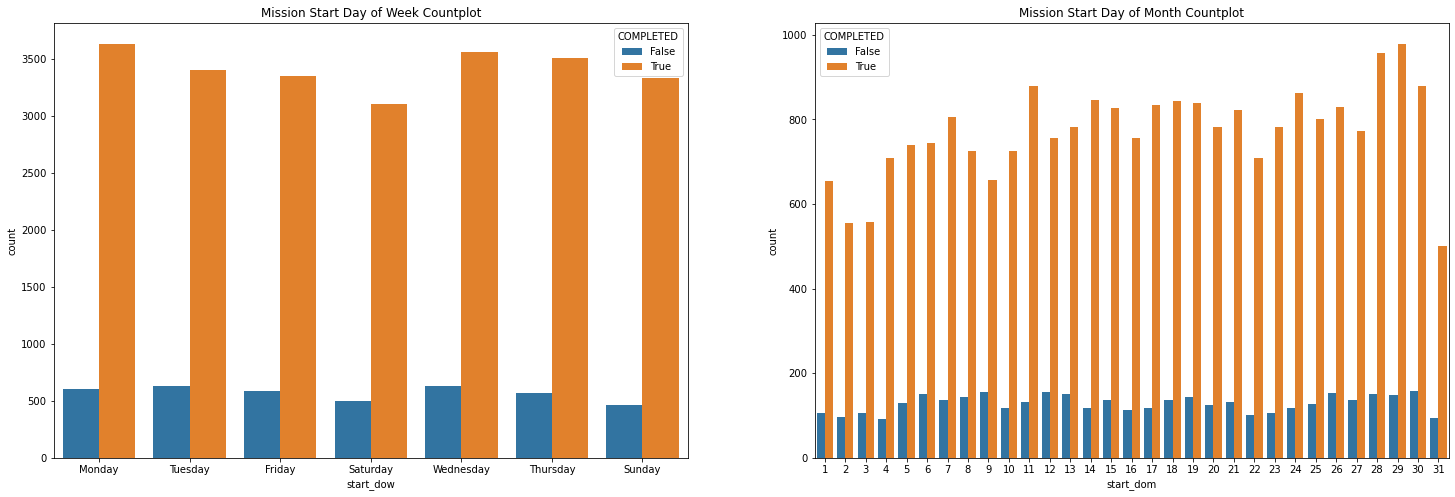

In [21]:
# Users behavioral data analysis based on the mission table

missionplot = {
    "start_dow":0,
    "start_dom":1
}

fig, axs = plt.subplots(1, 2, figsize = (25, 8))
for i in missionplot:
    sns.countplot(x = i, data = mission_df, hue = "COMPLETED", ax = axs[missionplot[i]])

axs[0].set_title("Mission Start Day of Week Countplot")
axs[1].set_title("Mission Start Day of Month Countplot")
plt.show()

Insights:

- (Left figure): plot the relationship between mission start day (weekday) and how many completed/incompleted missions on each day

    - It seems like users do not have a favorite day to start their missions. However, fewer users decided to launch their missions on Saturday.

- (Right figure): plot the relationship between mission start day (day of month) and how many completed/incompleted missions on each day

    - Users generally prefer to launch their missions after the middle of a month. Users generally do not start their missions at the beginning of a month (day 31 and day 1-5). It is probably due to seasonality effect. The analysis is based on mission data from Oct 2018 to Dec 2018. The Halloween is at the end of October, the Thanksgiving is at the end of November, and the Christmas Day and New Year's Eve are at the end of December. The data tells us that users do not like interacting with missions during major holidays.

    - We can send out reminder e-mail and app notification to encourage users to interact with missions during major holidays 

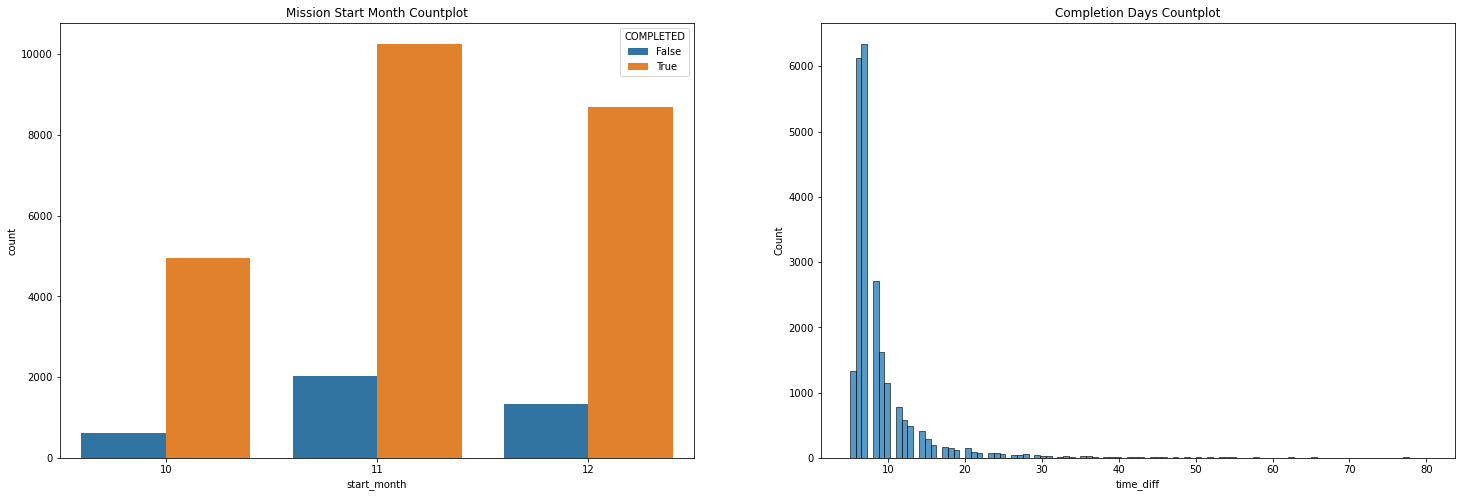

In [22]:
# Users behavioral data analysis based on the mission table

fig, axs = plt.subplots(1, 2, figsize = (25, 8))

sns.countplot(x = "start_month", data = mission_df, hue = "COMPLETED", ax = axs[0])
sns.histplot(x = "time_diff", data = mission_df[mission_df["time_diff"] <= 80], stat = "count", bins = 100, ax = axs[1])

axs[0].set_title("Mission Start Month Countplot")
axs[1].set_title("Completion Days Countplot")
plt.show()

Insights:

- (Left figure): countplot of relationship between mission start month and how many completed/incompleted missions on each month

    - Since October data is significantly different from November and December data, I assume that October was the month the mission feature was introduced. So, the feature is still in Introducation/Growth stages. When a new feature is announced, it usually suffers from bugs and attracting enough customers. One problem is that December's metric decreased a lot comparing with November's metric. Since I only have 3 months data, and such variation is usually normal for a new feature, I assume that such variation is due to seasonality and an unstable customer base.

- (Right figure): plot the relationship between days used to complete a mission and how many missions completed

    - Majority of the missions were completed within 10 days. To improve the mission feature, we can customize some conversations to remind users who spent more than 10 days on a mission and encourage those users to continue interacting with their missions.

In [23]:
# conversion rate for each mission_id

conversion = mission_df.groupby("mission_id")["COMPLETED"].sum()
conversion = (conversion/conversion.shift(1)).reset_index()

In [24]:
conversion.loc[0,"COMPLETED"] = mission_df.groupby("mission_id")["COMPLETED"].sum()[1]/mission_df[mission_df["mission_id"] == 1]["mission_id"].count()

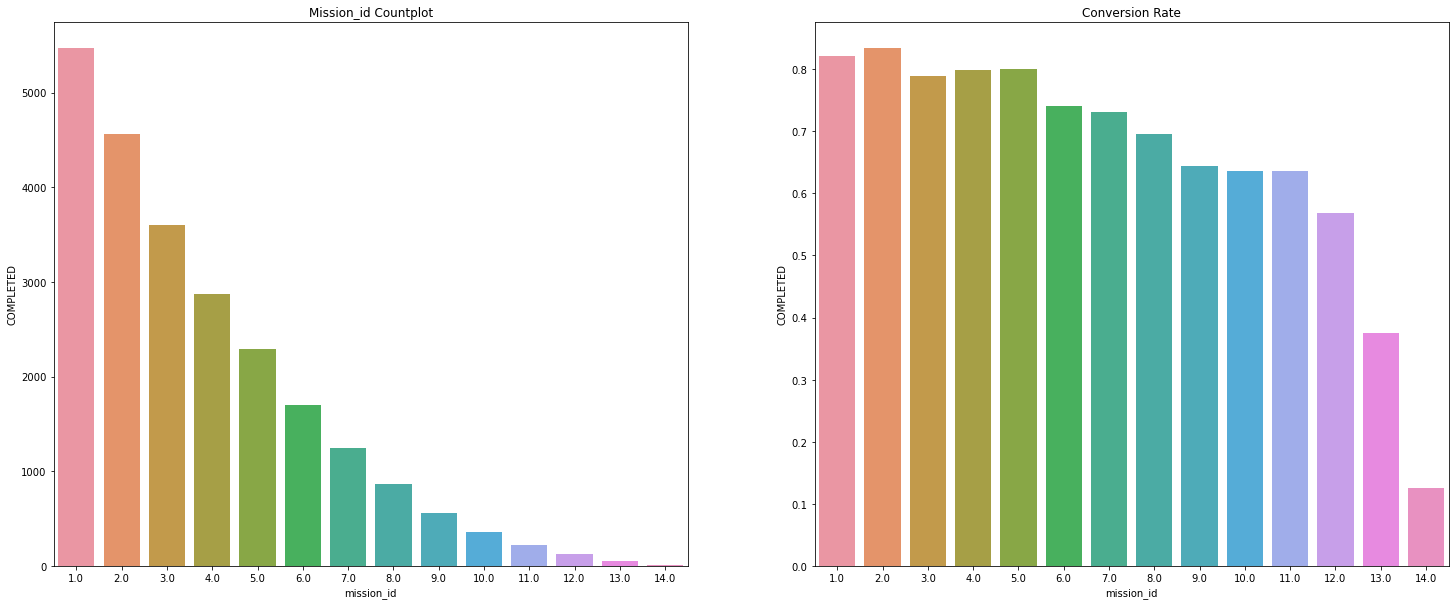

In [25]:
# Plot mission conversion rate and mission_id countplot

fig, axs = plt.subplots(1, 2, figsize = (25, 10))

sns.barplot(x = "mission_id", y = "COMPLETED", data = conversion, ax = axs[1])
sns.barplot(x = "mission_id", y = "COMPLETED", data = mission_df.groupby("mission_id")["COMPLETED"].sum().reset_index(), ax = axs[0])
axs[1].set_title("Conversion Rate")
axs[0].set_title("Mission_id Countplot")
plt.show()

Insights:

- (Left figure): Since the missions are given by order. We can do a funnel analysis here.

- (Right figure): The conversion rates of the first 5 missions are stable. But the rate gradually decreases after that.

    - We can analyze users feedbacks on missions 6 - 16 to better improve those missions and send rewards to incentive users to complete those missions.

    - Users may get bored after doing 5 missions. So maybe we can change the remaining missions' format or try to redesign those missions and just launch 5 missions but include more contents.

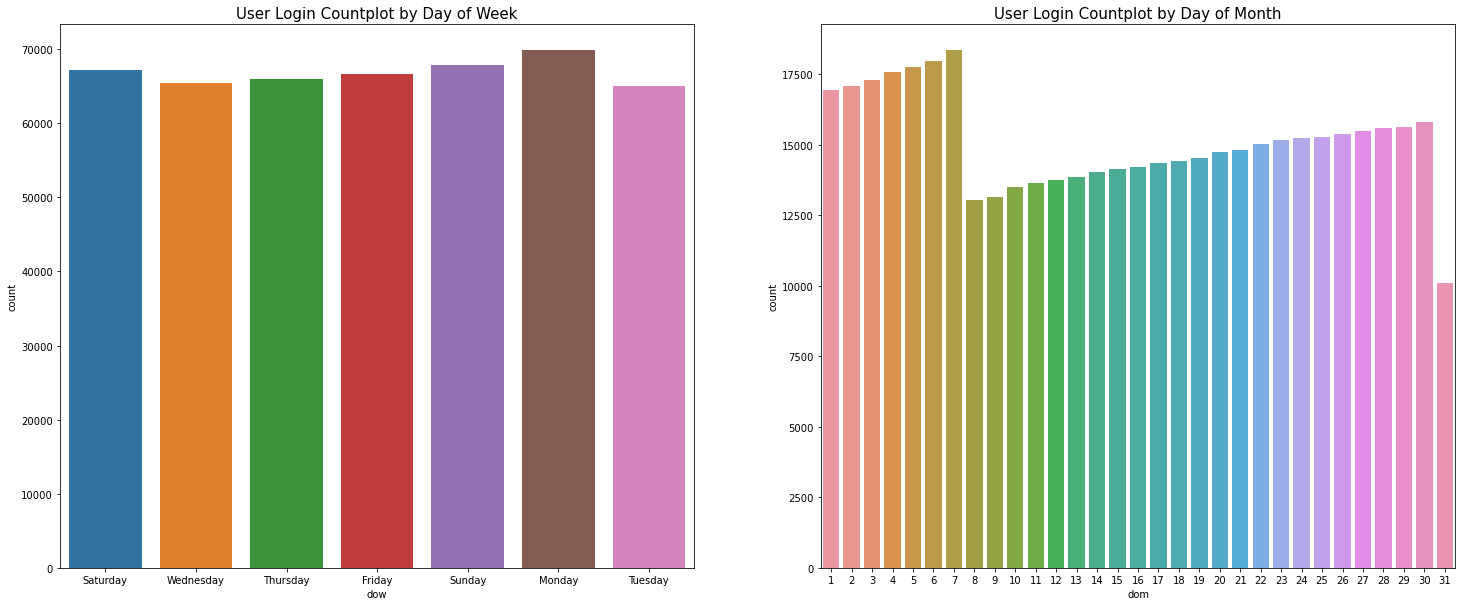

In [26]:
# Users engagement analysis based on the agg_info table
fig, axs = plt.subplots(1, 2, figsize = (25,10))

sns.countplot(x = "dow", data = agg_info_df, ax = axs[0])
sns.countplot(x = "dom", data = agg_info_df, ax = axs[1])
axs[0].set_title("User Login Countplot by Day of Week", fontsize = 15)
axs[1].set_title("User Login Countplot by Day of Month", fontsize = 15)
plt.show()

Insights:

- (Left figure): plot relationship between login days (weekday) and total login times

    - The total login count is approximately equally distributed among 7 weekdays.

- (Right figure): plot relationship between login days (day of month) and total login times

    - Users generally login the app a lot at the beginning of a month, especially during the first week of a month. It is an interesting finding, because we previously discovered that users do not like starting missions at the beginning of a month. Two possibilities are:

        - There might be a technical issue happened on the Oct/Nov/Dec 8th or 31st. Because the magnitude of drops is very obvious.

        - The wording of mission conversation causes stress, or maybe it just sounds a little bit hard to achieve. So many users see the mission at the beginning of a month but decide to postpone the mission start date.

In [27]:
# create two aggregated table, one groupby day of week, one group by day of month for data analysis

dow_agg = agg_info_df.groupby("dow").agg(
    avg_convos = ("NUM_CONVOS", np.mean),
    avg_actvity_time = ("TOTAL_ACTIVITY_MINUTES2", np.mean),
    avg_activity_num = ("NUM_ACTIVITY_MEASUREMENTS", np.mean)).reset_index()

dom_agg = agg_info_df.groupby("dom").agg(
    avg_convos = ("NUM_CONVOS", np.mean),
    avg_actvity_time = ("TOTAL_ACTIVITY_MINUTES2", np.mean),
    avg_activity_num = ("NUM_ACTIVITY_MEASUREMENTS", np.mean)).reset_index()

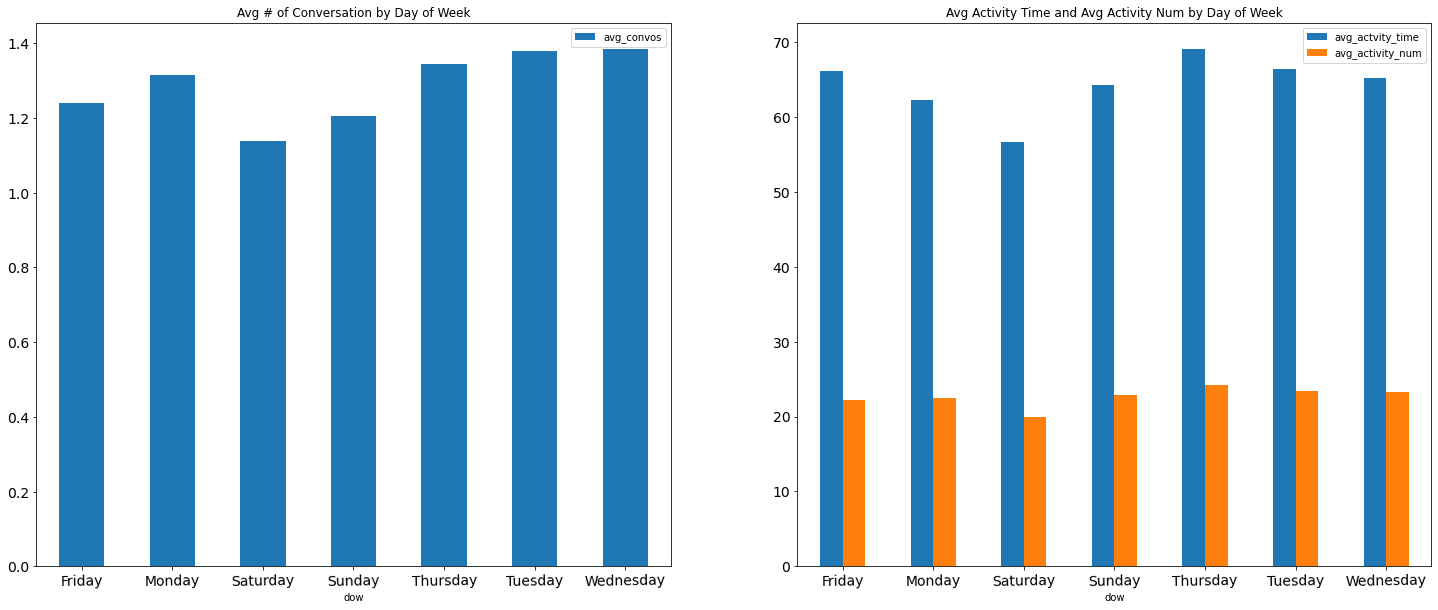

In [28]:
# users engagement analysis based on the day of week table

fig, axs = plt.subplots(1, 2, figsize = (25, 10))

dow_agg.plot(x = "dow", y = "avg_convos", kind = "bar", ax = axs[0], rot = 1, title = "Avg # of Conversation by Day of Week", fontsize = 14)
dow_agg.plot(x = "dow", y = ["avg_actvity_time", "avg_activity_num"], kind = "bar", ax = axs[1], rot = 1, title = "Avg Activity Time and Avg Activity Num by Day of Week", fontsize = 14)
plt.show()

Insights:

- (Left figure): plot the relationship between user login day (weekday) and average number of conversations

    - Generally, users do less conversation with the app on weekends (Friday to Sunday).

- (Right figure): plot the relationship between user login day (weekday) and average activity time/average activity number

    - Users initiate less activity and spend less time on activities on Saturday.

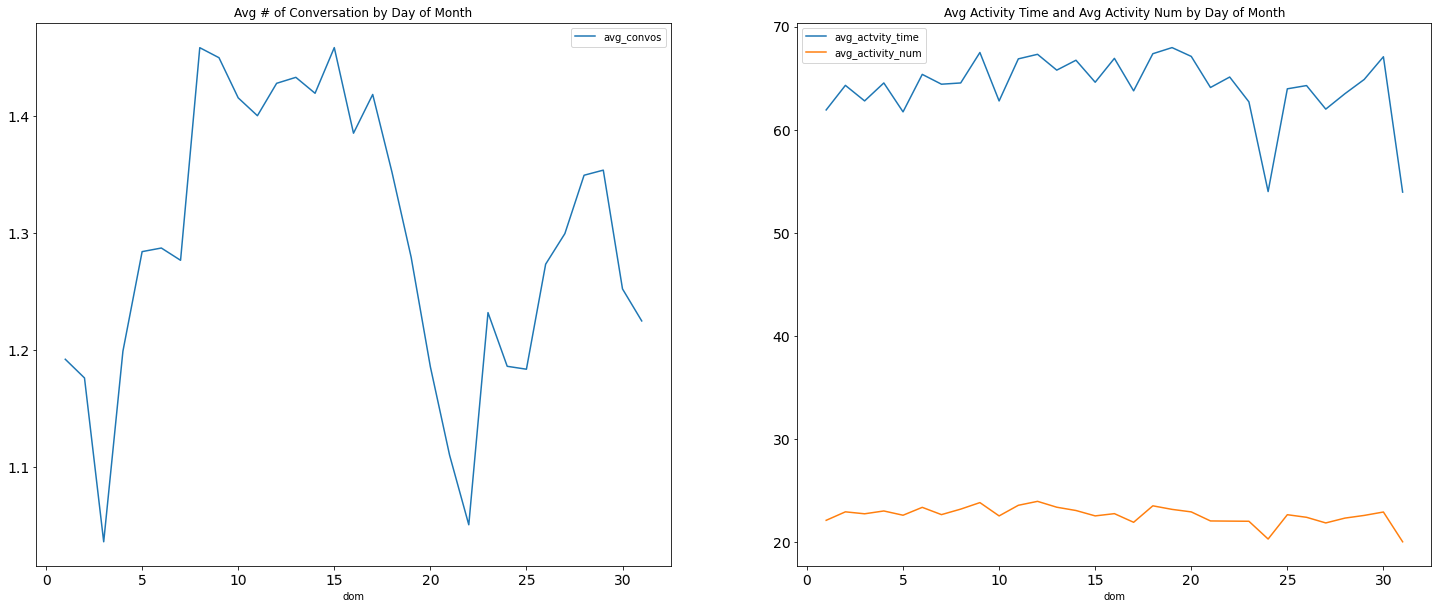

In [29]:
# users engagement analysis based on the day of month table

fig, axs = plt.subplots(1, 2, figsize = (25, 10))

dom_agg.plot(x = "dom", y = "avg_convos", kind = "line", ax = axs[0], rot = 1, title = "Avg # of Conversation by Day of Month", fontsize = 14)
dom_agg.plot(x = "dom", y = ["avg_actvity_time", "avg_activity_num"], kind = "line", ax = axs[1], rot = 1, title = "Avg Activity Time and Avg Activity Num by Day of Month", fontsize = 14)
plt.show()

Insights:

- (Left figure): plot the relationship between user login day (day of month) and average number of conversations

    - Although lots of logins happened during the first week of a month, those logins did not contribute lots of conversations. However, the average activity time and number do not drop a lot during the first week of a month. So, many users login during the first week of month and they spent a reasonable amount of time on activities but just do not actively engage with the conversation feature. This may due to:

        - There were many test accounts during the first week of one or more of the three months, those accounts can bypass conversation to directly test certain activities.

        - Users who login a lot during the first week of a month are a group of users who only perform certain activities that do not require lots of conversations. And they usually engage in those activities at the beginning of each month.

- (Right figure): plot the relationship between user login day (day of month) and average activity time/average activity number

    - Average activity time/number drop at the end of each month. This may be due to seasonality.

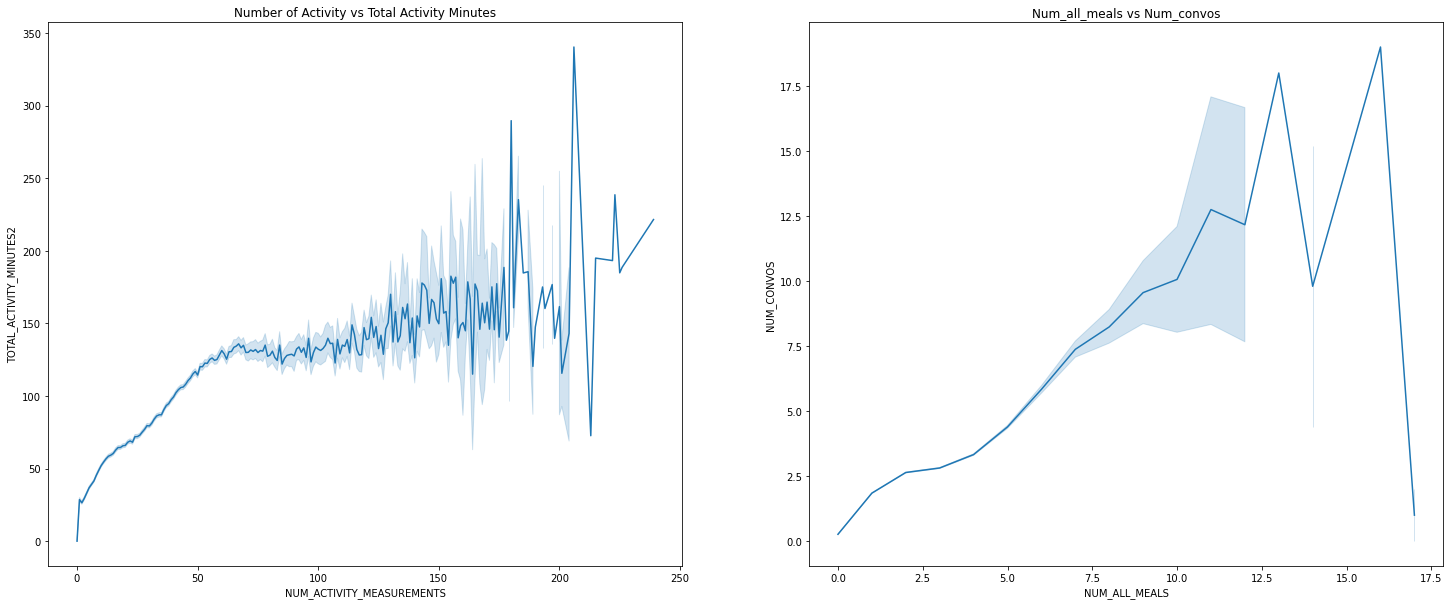

In [30]:
# users engagement analysis based on the agg_info table

fig, axs = plt.subplots(1, 2, figsize = (25, 10))

sns.lineplot(x = "NUM_ACTIVITY_MEASUREMENTS", y = "TOTAL_ACTIVITY_MINUTES2", data = agg_info_df[agg_info_df["NUM_ACTIVITY_MEASUREMENTS"] <= 250], ax = axs[0]).set_title("Number of Activity vs Total Activity Minutes")
sns.lineplot(x = "NUM_ALL_MEALS", y = "NUM_CONVOS", data = agg_info_df, ax = axs[1]).set_title("Num_all_meals vs Num_convos")

plt.show()

Insights:

- (Left figure) plot the relationship between the number of activity and the total activity minutes

    - Users generally do not spend more than 150 minutes on activities per login. Even some users engaged more than 100 features, they still do not spend more than 150 minutes on activities. Maybe there are many activities that only require a small amount of time to finish, or some users just start an activity and quickly abandon. 

- (Right figure) plot the relationship between number of all meals and number of conversations

    - An approximate positive relationship between the two features. There are a few outliers, possibly due to test accounts.

<h2>Model Building</h2>

I used a random forest model to predict how many completed missions a user may achieve based on engagement related features. Random forest regressor handles correlated features very well and usually performs well. Using h2o Random Forest, one can easily plot the feature importance and partial dependence of the model, which are valuable in terms of generating insights.

In [31]:
# initiate a h2o instance

h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmp0lfmfxth
  JVM stdout: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmp0lfmfxth/h2o_haorzeng_started_from_python.out
  JVM stderr: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmp0lfmfxth/h2o_haorzeng_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Indiana/Indianapolis
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,5 months !!!
H2O_cluster_name:,H2O_from_python_haorzeng_nucsoo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [32]:
# Convert df to H2OFrame

h2o_df = H2OFrame(df)

h2o_df["favorite_dow"] = h2o_df["favorite_dow"].asfactor() # H2O Random Forest automatically applies Label Encoder on categorical values
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,USER_ID,avg_convos,total_convos,avg_meals,avg_activity_time,avg_activity_num,avg_num_weights,avg_num_notifs,total_login_count,favorite_dow,mission_count
type,int,real,int,real,real,real,real,real,int,enum,int
mins,164106.0,0.13095238095238096,6.0,0.0,0.0,0.0,0.0,0.0,3.0,,0.0
mean,1441663.258132217,1.3304488376142847,90.24509069105085,1.0296645494940488,63.536764363685045,22.046170916532464,0.19432759513484055,1.9730997000233235,70.16039574276742,,3.5849198021286153
maxs,1520428.0,8.354430379746836,660.0,5.538461538461538,438.6340127285715,122.4125,4.363636363636363,3.396551724137931,99.0,,14.0
sigma,70035.76466026054,0.8914103229998576,64.07078436232561,0.8205447690681068,42.466038928303234,15.327595496393691,0.2578570087257304,0.669770615410188,20.8342584058475,,3.125885612012127
zeros,0,0,0,10,2,2,185,90,0,,1202
missing,0,0,0,0,0,0,0,0,0,0,0
0,164106.0,1.5454545454545454,102.0,1.818181818181818,134.1439214242424,76.34848484848484,0.3484848484848485,1.9242424242424243,66.0,Monday,7.0
1,185934.0,1.8157894736842104,69.0,1.1578947368421053,116.77152702631577,35.1578947368421,0.7105263157894737,1.631578947368421,38.0,Tuesday,2.0
2,277541.0,0.631578947368421,36.0,0.8070175438596491,49.50315037894736,29.56140350877193,0.21052631578947367,2.4210526315789473,57.0,Monday,3.0


In [33]:
# train test split
train, test = h2o_df.split_frame(ratios = [0.85]) # 85% train data, 15% test data

features = ["avg_convos", "avg_meals", "avg_activity_time", "avg_activity_num", "avg_num_weights", "avg_num_notifs", "total_login_count", "favorite_dow"] # drop USER_ID column since it is not useful for prediction
target = "mission_count"

In [34]:
# define classfier
clf = H2ORandomForestEstimator(ntrees = 100)

In [35]:
# train the model
clf.train(x = features, y = target, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
# Model performance on train data
clf.model_performance()


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1.7591199969233675
RMSE: 1.3263182110351073
MAE: 0.9767240354327273
RMSLE: 0.3503768776939971
Mean Residual Deviance: 1.7591199969233675


In [37]:
# Model performance on test data
ypred = clf.predict(test).as_data_frame().values
ytrue = test["mission_count"].as_data_frame().values

mae = mean_absolute_error(ytrue, ypred)
print("MAE on test data: {}".format(mae))

drf prediction progress: |████████████████████████████████████████████████| 100%
MAE on test data: 0.9767111306214405


The random forest model achieved mean absolute error ~0.97 on train data and ~0.97 on test data

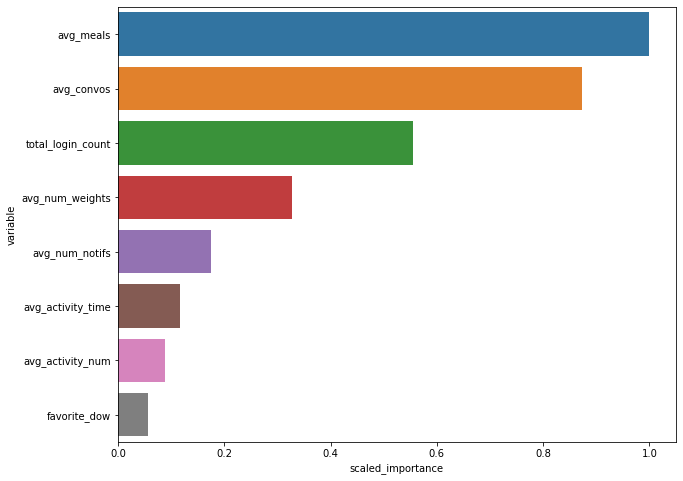

In [38]:
# Feature importance
importance = clf.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

Insights:

- Top 3 most important features in terms of predicting the number of completed missions: avg_meals, avg_convos, total_login_count. 

    - The three features are proxies of engagement. In other words, users who engage frequently with other features of the app generally engage actively with the mission feature.

- avg_meals

    - People who record meals are those who persistently monitor their health conditions and want to get feedback from Lark about how to eat healthy. Lark can continue marketing mission features to this group of people because they demand such feature to improve their health conditions. For those who actively participate other activities buy do not record meals frequently, Lark can customize conversations/notifications to help them realize the importance of tracking food intakes.

- avg_convos

    - Since users need to do conversations to complete missions, users who enjoy doing conversations are more likely to accept the delivery format of mission feature. But for users who do not like the conversation format, the delivery format of mission maybe a bummer. One thing we can do to help those users engage is to create a second entrance, which is in "fill-in-the-blank" format or "multiple choice" format.

- total_login_count

    - As mentioned before, we can encourage users to login and interact with the app by introducing some incentive programs.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


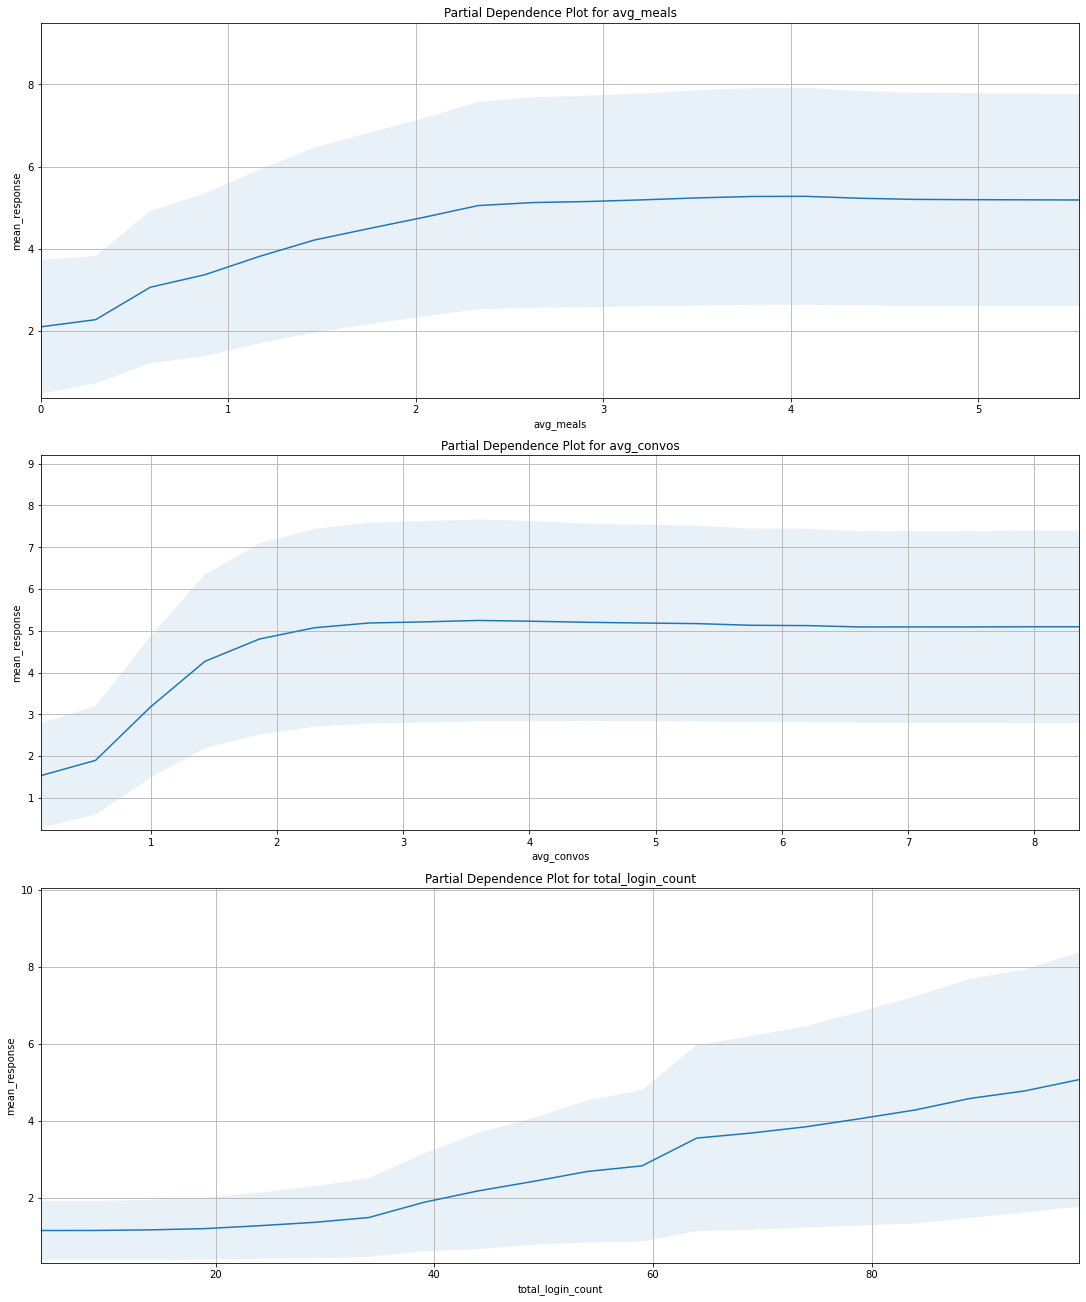

In [39]:
# Partial dependence plot
cols = ["avg_meals", "avg_convos", "total_login_count"]
_ = clf.partial_plot(data = train, cols = cols, figsize = (15, 18))

Insights:

- avg_meals

    - The critical value is ~3. For users whose avg_meals are below 2.5, Lark can send conversation or incentivized reminder to encourage them document more meals information and provide meals related missions. 

- avg_convos

    - The critical value is ~3.5. To improve the conversation feature, we can investigate the text information of each conversation and users' customer service tickets related to conversation. For those who do not like conversation format, we can create a second entrance, which can be "fill-in-the-blank" format or "multiple choice" format.

- total_login_count

    - In general, users who login more tend to complete more missions. To encourage users login more, we can send reminder e-mail/notification during holidays and introduce a incentive program.

In [40]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_ac34 closed.
